In [262]:
import os
import sys
import yaml
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
import matplotlib.colors as mc
import colorsys

sys.path.append(str(Path.cwd().parent / "scripts"))
from _fes_helpers import (
    get_data_point,
    scenario_mapper,
    get_gb_total_transport_demand,
    # get_gb_total_number_cars,
    get_total_cars,
    get_smart_charge_v2g,
    get_power_generation_emission,
    get_battery_capacity,
    get_industrial_demand,
    get_commercial_demand,
    get_import_export_balance,
    get_electric_heat_demand,
    get_industrial_hydrogen_demand,
    get_heating_shares,
    get_v2g_share,
    get_electrolysis_capacity,
    get_distributed_generation,
)

idx = pd.IndexSlice

In [263]:
with open(Path.cwd().parent / "config" / "config.yaml") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]

In [264]:
(Path.cwd() / "sfadijvsdj d.csv").is_file()

False

In [265]:
def adjust_lightness(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [269]:
from itertools import product

fn = "temp_data.csv"
fes_file = Path.cwd().parent / "data" / "FES 2023 Data Workbook V001.xlsx"
fes_file_2022 = Path.cwd().parent / "data" / "Data-workbook2022_V006.xlsx"

if not (Path.cwd() / fn).is_file():

    results = pd.DataFrame(
        index=pd.MultiIndex.from_product([
            ("LW", "FS"),
            range(2024, 2051),
            ]),
        columns=[
            "number_evs",
            "emission",
            "onshore_wind", 
            "offshore_wind", 
            "solar", 
            "embedded_generation", 
            "electric_heating_demand",
            "industrial_hydrogen_demand",
            ]
        )

    funcs = [
        get_data_point,
        get_power_generation_emission,
        get_data_point,
        get_data_point,
        get_data_point,
        get_distributed_generation,
        get_electric_heat_demand,
        get_industrial_hydrogen_demand,
    ]

    args = [
        ["bev_cars_on_road"],
        [fes_file],
        ["onshore_wind_capacity"],
        ["offshore_wind_capacity"],
        ["solar_capacity"],
        [],
        [],
        [],
    ]

    for (col, func, arg), i in product(zip(results.columns, funcs, args), results.index):

        scenario, year = i
        arg = arg + [scenario, year]
    
        val = func(*arg)
    
        if col == "emission":
            val = val[0] - val[1] - val[2]
        elif col == "electric_heating_demand":
            val = val[1]

        results.loc[idx[scenario, year], col] = val

    results.to_csv(fn)
else:
    results = pd.read_csv(fn, index_col=[0, 1])


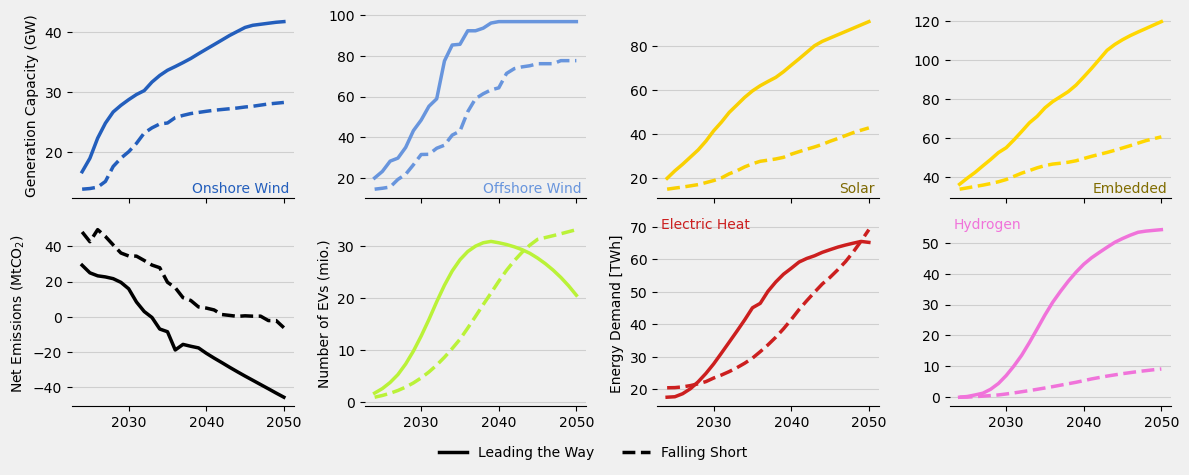

In [271]:
from matplotlib.lines import Line2D

col_order = [
    "onshore_wind", 
    "offshore_wind", 
    "solar", 
    "embedded_generation", 
    "emission",
    "number_evs",
    "electric_heating_demand",
    "industrial_hydrogen_demand",
    ]

fig, axs = plt.subplots(2, 4, figsize=(12, 4.5))

shared_kwargs = {"linewidth": 2.5}
line_kwargs = dict(
    LW=dict(),
    FS=dict(linestyle="--"),
)

colors = [
    "#235ebc",
    "#6895dd",
    "#f9d002",
    'gold',
    'k',
    '#baf238',
    '#cc1f1f',
    "#f073da"
    ]
background_color = "#f0f0f0"


factors = [1e-3, 1e-3, 1e-3, 1e-3, 1, 1e-6, 1e-6, 1e-6]

for ax, col, color, factor in zip(axs.flatten(), col_order, colors, factors):

    for scen in results[col].unstack().T.columns:
        results[col].unstack().T[scen].mul(factor).plot(ax=ax, color=color, **shared_kwargs, **line_kwargs[scen])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(True, linestyle="-", alpha=0.5, axis="y")
    ax.set_facecolor(background_color)

fig.patch.set_facecolor(background_color)

for ax in axs.flatten()[:4]:
    ax.set_xticklabels([])

handles = [Line2D([0], [0], color="k", **shared_kwargs, **line_kwargs[scen]) for scen in line_kwargs.keys()]
nice_labels = {"LW": "Leading the Way", "FS": "Falling Short"}
labels = [nice_labels[scen] for scen in line_kwargs.keys()]

axs[0,0].set_ylabel("Generation Capacity (GW)")
axs[1,0].set_ylabel(r"Net Emissions (MtCO$_2$)")
axs[1,1].set_ylabel("Number of EVs (mio.)")
axs[1,2].set_ylabel("Energy Demand [TWh]")

for c, text, ax in zip(
    colors[:2] + [adjust_lightness(c, 0.5) for c in colors[2:4]],
    ["Onshore Wind", "Offshore Wind", "Solar", "Embedded"], axs[0]):
    ax.text(
        0.98, 0.05,
        text,
        horizontalalignment='right',
        verticalalignment='center',
        transform=ax.transAxes,
        color=c,
        )

for c, text, ax in zip(colors[-2:], ["Electric Heat", "Hydrogen"], axs.flatten()[-2:]):
    ax.text(
        0.02, 0.98,
        text,
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes,
        color=c,
        )

plt.tight_layout()
axs[1,0].legend(
    handles,
    labels,
    bbox_to_anchor=(3.1, -0.36),
    loc='lower right',
    frameon=False,
    fancybox=False,
    ncol=2,
)

plt.savefig("fes_future_capacities.pdf", bbox_inches="tight")
plt.show()

In [192]:
n = pypsa.Network(Path.cwd().parent / "results" / "pypsa-fes" / "networks" / f"elec_s_ec_lhnd___LW_2045.nc")

INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd___LW_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
C:\Users\lukas\AppData\Local\Temp\ipykernel_25708\2847124876.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


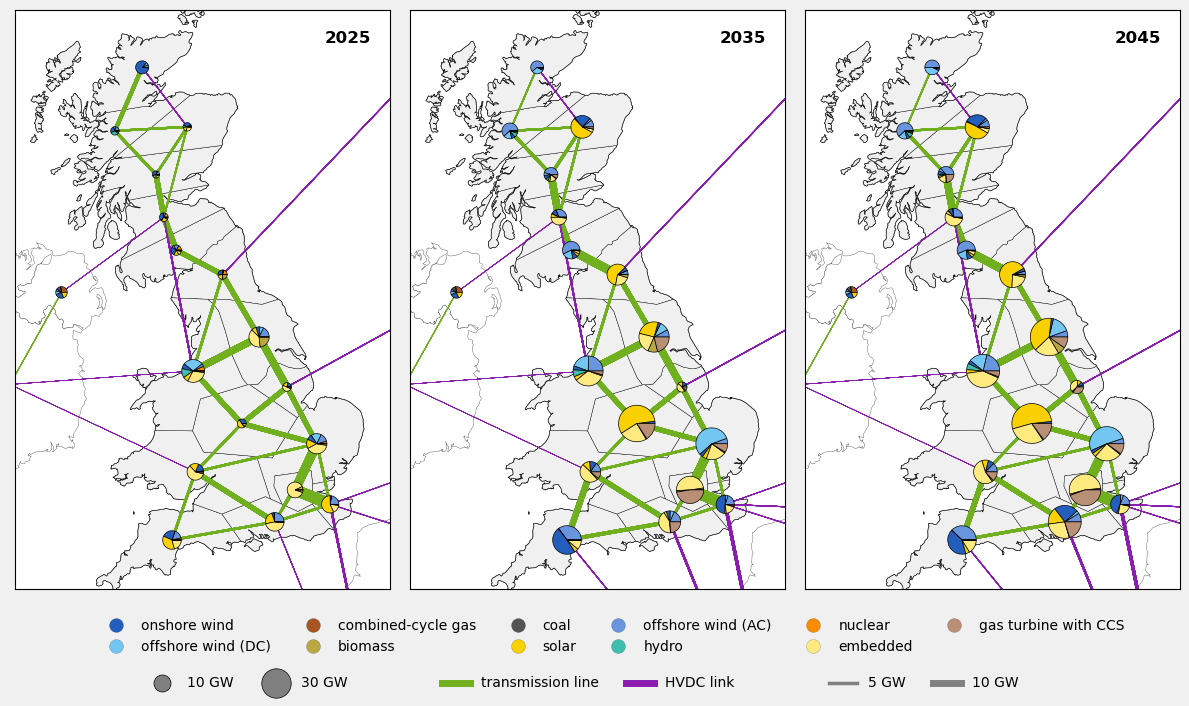

In [270]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from shapely.ops import unary_union


regions = (
    gpd.read_file(
        Path.cwd().parent /
        "resources" /
        "pypsa-fes" /
        "regions_onshore_elec_s_eso.geojson")
        .set_index("name")
        [["geometry"]]
)
non_gb = regions.loc[~regions.index.str.contains("GB")]
gb = regions.loc[regions.index.str.contains("GB")]

fig, axs = plt.subplots(1, 3, figsize=(12, 10))


for ax in axs:

    gpd.GeoSeries([unary_union(gb.geometry)]).plot(ax=ax, color=background_color, edgecolor="black", linewidth=0.7)
    gb.plot(ax=ax, color=background_color, edgecolor="black", linewidth=0.3)
    non_gb.plot(ax=ax, color="w", edgecolor="black", linewidth=0.2)

    ax.set_xlim(-8, 2.5)
    ax.set_ylim(49, 60)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

# for region, geom in gb.items():

linkgens = ["biomass", "allam", "nuclear", "modular nuclear"]

totals = pd.Series()

# for i in range(len(gb)):

all_carriers = set()

for ax, year in zip(axs, [2025, 2035, 2045]):

    n = pypsa.Network(Path.cwd().parent / "results" / "pypsa-fes" / "networks" / f"elec_s_ec_lhnd___LW_{year}.nc")
    
    for region in gb.index.tolist() + [non_gb.loc[non_gb.index.str.contains("NI")].index[0]]:

        # region = gb.index[i]
        # geom = gb.iloc[i].geometry
        geom = regions.loc[region, "geometry"]

        center = geom.centroid.coords[0]
        # print(center)

        gen = n.generators.loc[n.generators.bus.str.contains(region), ["p_nom_opt", "carrier"]]

        gen2 = n.links.loc[(n.links.bus1.str.contains(region)) &
                        (n.links.carrier.isin(linkgens)),
                        ["p_nom_opt", "carrier", "efficiency"]]

        gen = pd.concat([
            gen.set_index("carrier").rename(columns={"p_nom_opt": "p_nom"})["p_nom"],
            (g := gen2.set_index("carrier")).rename(columns={"p_nom_opt": "p_nom"})["p_nom"].mul(g.efficiency),
        ]).mul(1e-3)
        total = gen.sum()

        # target_radius = 0.15
        gen_target_area = 0.15
        gen_target_capacity = 10

        # radius = total / target_capacity * target_radius
        radius = np.sqrt(total / gen_target_capacity * gen_target_area / np.pi)

        if radius == 0.:
            continue

        gen /= total
        for carrier in gen.index: all_carriers.add(carrier)

        pie_colors = [tech_colors[tech] for tech in gen.index]
        totals.loc[region] = total

        for line, row in n.lines.iterrows():

            x0, y0 = regions.loc[row.bus0, "geometry"].centroid.coords[0]
            x1, y1 = regions.loc[row.bus1, "geometry"].centroid.coords[0]

            l_target_width = 0.5
            l_target_capacity = 1

            width = row.s_nom_opt * 1e-3 / l_target_capacity * l_target_width

            ax.plot([x0, x1], [y0, y1], color=tech_colors["AC-AC"], linewidth=width)


        for link, row in n.links.loc[n.links.carrier == "DC"].iterrows():

            x0, y0 = regions.loc[row.bus0, "geometry"].centroid.coords[0]
            x1, y1 = regions.loc[row.bus1, "geometry"].centroid.coords[0]

            width = row.p_nom * 1e-3 / l_target_capacity * l_target_width
            ax.plot([x0, x1], [y0, y1], color=tech_colors["HVDC links"], linewidth=width)

        pie_kwargs = dict(
            wedgeprops=dict(
                edgecolor="black",
                linewidth=0.5,
            )
        )

        def plot_pie_inset(data, ilon, ilat, ax):
            ax_sub= inset_axes(ax, width=radius, height=radius, loc=10, 
                            bbox_to_anchor=(ilon, ilat),
                            bbox_transform=ax.transData, 
                            borderpad=0)
            wedges, texts= ax_sub.pie(data, colors=pie_colors, radius=1, **pie_kwargs)
        
        plot_pie_inset(gen.values, center[0], center[1], ax)

handles = [
    Line2D(
        [0], [0], marker='o',
        color=background_color,
        markerfacecolor=tech_colors[tech],
        # markersize=np.sqrt(target_area / np.pi),
        markersize=10,
        markeredgecolor="black",
        markeredgewidth=0.1,
        linewidth=1
        )
    for tech in all_carriers]

nice_names = {
    "onwind": "onshore wind",
    "offwind-ac": "offshore wind (AC)",
    "offwind-dc": "offshore wind (DC)",
    "solar": "solar",
    "solar rooftop": "embedded",
    "CCGT": "combined-cycle gas",
    "allam": "gas turbine with CCS",
    "ror": "hydro",
}

labels = [nice_names.get(tech, tech) for tech in all_carriers]

target_area = 0.15
target_capacity = 10


plt.tight_layout()

axs[0].legend(
    handles,
    labels,
    bbox_to_anchor=(0.2, -0.03),
    loc='upper left',
    frameon=False,
    fancybox=False,
    ncol=len(all_carriers)//2 + 1,
)

for ax in axs:
    ax.set_xlim(-8, 2.5)
    ax.set_ylim(50, 59)

fig.patch.set_facecolor(background_color)

for text, ax in zip(["2025", "2035", "2045"], axs):
    ax.text(
        0.95, 0.95,
        text,
        horizontalalignment='right',
        verticalalignment='center',
        transform=ax.transAxes,
        color="k",
        weight="bold",
        fontsize=12,
        )

factor = 56

handles = [
    Line2D(
        [0], [0], marker='o',
        color=background_color,
        markerfacecolor="grey",
        # markersize=np.sqrt(target_area / np.pi),
        markersize=np.sqrt(area / gen_target_capacity * gen_target_area / np.pi) * factor,
        markeredgecolor="black",
        markeredgewidth=0.5,
        # linewidth=1,
    ) 
    for area in [10, 30]
] + [Line2D([0], [0], color=background_color)] + [
    Line2D([0], [0], color=tech_colors[key], linewidth=5) for key in ["AC-AC", "HVDC links"]
] + [Line2D([0], [0], color=background_color)] + [
    Line2D([0], [0], color="grey", linewidth=cap / l_target_capacity * l_target_width)
    for cap in [5, 10]
]

labels = [f"{area} GW" for area in [10, 30]] + [""] + ["transmission line", "HVDC link"] + [""] + ["5 GW", "10 GW"]

axs[1].legend(
    handles,
    labels,
    bbox_to_anchor=(-.73, -0.13),
    loc='upper left',
    frameon=False,
    fancybox=False,
    ncol=10,
)


plt.savefig("fes_future_capacities_map.pdf", bbox_inches="tight")
plt.show()


In [169]:
n.generators.loc[n.generators.bus.str.contains("GB")].carrier.unique()

array(['offwind-ac', 'onwind', 'solar', 'offwind-dc', 'ror', 'coal',
       'lignite', 'gas', 'solar rooftop'], dtype=object)

In [138]:
gen.rename(columns={"p_nom_opt": "p_nom"})["p_nom"]

Generator
GB0 Z7 offwind-ac         987.694590
GB0 Z7 offwind-dc          53.799305
GB0 Z7 onwind             790.510458
GB0 Z7 solar            14482.735982
GB0 Z7 solar rooftop     4942.932418
Name: p_nom, dtype: float64